In [1]:
import pandas as pd
import numpy as np
import os
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
matplotlib.rcParams['axes.unicode_minus'] = False
pd.options.mode.chained_assignment = None  # default='warn'
plt.rcParams['font.family'] = 'Malgun Gothic'
import datetime

In [2]:
date_today = pd.to_datetime(datetime.datetime.now().strftime('%Y-%m-%d'), format='%Y-%m-%d')

In [3]:
date_today_record = str(date_today).split(' ')[0].replace('-', '')
date_today_record

'20210518'

In [4]:
def day_modifier(x):
    # x is a number
    
    if pd.isna(x) == True:
        return x
    else:
        x = str(x)
        if len(x) == 1:
            return '0' + x
        else:
            return x

In [5]:
def landnum_modifier(x):
    # x is a string
    
    if pd.isna(x) == True:
        return x
    else:
        x = str(x).replace('외', '').replace(' ','')
        splitted = x.split('-')
        if len(splitted) == 1:
            return x + '-0'
        else:
            return x

In [6]:
def data_prep(bdtype, tradetype):
    # bdtype is a string: one of 아파트, 연립다세대 or 오피스텔
    # tradetype is a string: one of 매매 or 전월세
    
    basedir = './국토교통부_실거래가_공개시스템/{}/{}/'.format(bdtype, tradetype)
    filenames = [f for f in os.listdir(basedir) if (f.endswith('.csv'))&('(' in f)]
    
    dfs_list = []
    for i, f in tqdm(enumerate(filenames)):
        df = pd.read_csv(basedir + f, encoding='euc-kr', header=15)
        if '해제사유발생일' in df.columns.tolist():
            df = df[df['해제사유발생일'].isna()]
            df = df.drop(columns=['해제사유발생일'])

        dfs_list.append(df)
    
    concat_df = pd.concat(dfs_list).reset_index(drop=True)
        
    concat_df['번지'] = concat_df['번지'].apply(landnum_modifier)
    
    concat_df['계약년월'] = concat_df['계약년월'].apply(str)
    concat_df['계약일'] = concat_df['계약일'].apply(str)
    
    concat_df['계약날짜기준_건물연식'] = concat_df['계약년월'].apply(lambda x: int(x[:4])) - concat_df['건축년도']
    
    concat_df['계약일'] = concat_df['계약일'].apply(day_modifier)
    
    concat_df['계약날짜'] = concat_df['계약년월'].apply(lambda x: x[:4]) + '-' + concat_df['계약년월'].apply(lambda x: x[-2:])\
    + '-' + concat_df['계약일']
    
    concat_df['계약날짜'] = pd.to_datetime(concat_df['계약날짜'], format='%Y-%m-%d')
    
    concat_df['거래금액(만원)'] = concat_df['거래금액(만원)'].apply(lambda x: int(x.replace(',','')))
    concat_df['단가(만원/㎡)'] = concat_df['거래금액(만원)'] / concat_df['전용면적(㎡)']
    
    concat_df['지번주소'] = concat_df['시군구'] + ' ' + concat_df['번지']
        
    cols_to_drop = ['시군구', '번지', '본번', '부번', '지번주소', '계약년월', '계약일', '도로명']
        
    concat_df = concat_df[['지번주소', '도로명'] + [col for col in concat_df.columns if col not in cols_to_drop]]
    
    date_today = pd.to_datetime(datetime.datetime.now().strftime('%Y-%m-%d'), format='%Y-%m-%d')
    concat_df['건물연식'] = date_today.year - concat_df['건축년도']
    
    concat_df = concat_df.dropna(subset=['지번주소'])
    
    if '건물명' in concat_df.columns:
        concat_df.rename(columns={'건물명':'건물(단지)명'}, inplace=True)
    elif '단지명' in concat_df.columns:
        concat_df.rename(columns={'단지명':'건물(단지)명'}, inplace=True)
    
    concat_df = concat_df[concat_df['층'] >= 0].reset_index(drop=True)
    
    return concat_df

In [7]:
target_house = '연립다세대'
house_df = data_prep(target_house, '매매')
print(house_df.shape)
house_df.head()

16it [00:01, 11.28it/s]


(632813, 12)


,지번주소,도로명,건물(단지)명,전용면적(㎡),대지권면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식
0,서울특별시 강남구 개포동 171-13,선릉로14길 11,(171-13),68.08,56.10,56500,2,1988.0,18.0,2006-12-20,829.905993,33.0
1,서울특별시 강남구 개포동 1239-7,개포로15길 25,강남빌라 가동,52.59,45.00,40500,2,1988.0,18.0,2006-12-09,770.108386,33.0
2,서울특별시 강남구 개포동 1239-7,개포로15길 25,강남빌라 가동,52.59,45.00,42000,1,1988.0,18.0,2006-12-19,798.630918,33.0
3,서울특별시 강남구 개포동 1239-6,개포로15길 27,강남빌라 나동,52.75,44.68,22000,2,1988.0,18.0,2006-11-02,417.061611,33.0
4,서울특별시 강남구 개포동 1175-2,논현로6길 36-8,강남파크,49.43,23.70,17000,4,1993.0,13.0,2006-07-19,343.920696,28.0


In [8]:
land_specs_df = pd.read_csv('./prepped_data/land_specs_ver_4.csv')
print(land_specs_df.shape)
land_specs_df.head()

(8706295, 11)


,지번주소,년,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면,공시지가
0,서울특별시 강남구 개포동 100-0,2013,전,876.0,자연녹지지역,지정되지않음,전,완경사,부정형,맹지,325000.0
1,서울특별시 강남구 개포동 100-0,2014,전,876.0,자연녹지지역,지정되지않음,전,완경사,부정형,맹지,330000.0
2,서울특별시 강남구 개포동 100-0,2015,전,876.0,자연녹지지역,지정되지않음,전,완경사,부정형,맹지,335000.0
3,서울특별시 강남구 개포동 100-0,2016,전,876.0,자연녹지지역,지정되지않음,전,완경사,부정형,맹지,345000.0
4,서울특별시 강남구 개포동 100-0,2017,전,876.0,자연녹지지역,지정되지않음,전,완경사,부정형,맹지,355000.0


In [9]:
last_df = land_specs_df.drop_duplicates(subset=['지번주소'], keep='last').drop(columns=['년', '공시지가']).reset_index(drop=True)
print(last_df.shape)
last_df.head()

(981464, 9)


,지번주소,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면
0,서울특별시 강남구 개포동 100-0,전,876.0,자연녹지지역,지정되지않음,전,완경사,부정형,맹지
1,서울특별시 강남구 개포동 101-0,전,641.0,자연녹지지역,지정되지않음,전,평지,부정형,맹지
2,서울특별시 강남구 개포동 102-0,전,509.0,자연녹지지역,지정되지않음,전,평지,부정형,맹지
3,서울특별시 강남구 개포동 103-0,전,48.7,자연녹지지역,개발제한구역,전,평지,부정형,맹지
4,서울특별시 강남구 개포동 104-1,전,2995.0,개발제한구역,자연녹지지역,전,완경사,부정형,맹지


In [10]:
house_merge_df = house_df.merge(last_df, on=['지번주소']).reset_index(drop=True)
print(house_merge_df.shape)

(630279, 20)


In [11]:
house_df['구'] = house_df['지번주소'].apply(lambda x: x.split(' ')[1])
house_df['동'] = house_df['지번주소'].apply(lambda x: x.split(' ')[2])
house_merge_df['구'] = house_merge_df['지번주소'].apply(lambda x: x.split(' ')[1])
house_merge_df['동'] = house_merge_df['지번주소'].apply(lambda x: x.split(' ')[2])

In [12]:
target_gu = '송파구'
target_dong = '석촌동'
target_purpose = '2종일반'
target_building_age = 5
target_period = 18 # in months

In [13]:
target_df = house_merge_df[
    (house_merge_df['구'] == target_gu)
    &(house_merge_df['동'] == target_dong)
    &(house_merge_df['계약날짜'] >= (date_today - pd.DateOffset(months=target_period)))
    &(house_merge_df['건물연식'] <= target_building_age)
    #&(house_merge_df['용도지역명1'].str.contains(target_purpose))
]
print(target_df.shape)
target_df.head()

(108, 22)


,지번주소,도로명,건물(단지)명,전용면적(㎡),대지권면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면,구,동
193790,서울특별시 송파구 석촌동 150-18,백제고분로37나길 13,엘리움파크,50.210,28.13,43000,2,2018.0,2.0,2020-01-14,856.403107,3.0,대,234.7,제2종일반주거지역,지정되지않음,다세대,평지,정방형,세로한면(가),송파구,석촌동
485929,서울특별시 송파구 석촌동 54-30,석촌호수로18길 8-58,레이크빌(54-30),49.420,23.85,30300,3,2017.0,3.0,2020-06-24,613.112100,4.0,대,190.9,제2종일반주거지역,지정되지않음,다세대,평지,세로장방,세로한면(가),송파구,석촌동
568042,서울특별시 송파구 석촌동 245-5,가락로5길 31-6,UNOHOUSE,53.195,28.76,41500,2,2016.0,4.0,2020-06-03,780.148510,5.0,대,198.6,제2종일반주거지역,지정되지않음,다세대,평지,가로장방,세로한면(가),송파구,석촌동
568043,서울특별시 송파구 석촌동 245-5,가락로5길 31-6,UNOHOUSE,53.195,28.76,44700,3,2016.0,4.0,2020-08-09,840.304540,5.0,대,198.6,제2종일반주거지역,지정되지않음,다세대,평지,가로장방,세로한면(가),송파구,석촌동
568044,서울특별시 송파구 석촌동 245-5,가락로5길 31-6,UNOHOUSE,53.195,28.76,42700,2,2016.0,4.0,2020-08-29,802.707021,5.0,대,198.6,제2종일반주거지역,지정되지않음,다세대,평지,가로장방,세로한면(가),송파구,석촌동


In [14]:
sales_idx_basedir = './한국부동산원/실거래가격지수/'
filenames = [f for f in os.listdir(sales_idx_basedir) if '연립다세대' in f]

sales_idx_df = pd.read_excel(sales_idx_basedir + filenames[0], header=[10, 11])

sales_idx_cols_list = []
for i in range(sales_idx_df.shape[1]):
    if i == 0:
        sales_idx_cols_list.append(sales_idx_df.columns[i][0])
    else:
        sales_idx_cols_list.append(sales_idx_df.columns[i][0] + '_' + sales_idx_df.columns[i][1])

sales_idx_df.columns = sales_idx_cols_list

In [15]:
def get_sales_idx(x):
    # x is a pandas timestamp
    
    df = sales_idx_df.copy()
    
    if pd.isna(x) == True:
        return x
    else:
        year = str(x.year)
        month = str(x.month)
        if len(month) == 1:
            month = '0'+month
        
        idx = df[year+'년 '+month+'월_지수'].iloc[0]
        
        return idx

In [16]:
def get_index_applied_prices(df):
    df = df.copy()
    
    last_idx = sales_idx_df.iloc[0,-2]
    
    last_date = sales_idx_df.columns[-1].split('_')[0]
    
    last_date = last_date.split(' ')[0].replace('년','') + '-' + last_date.split(' ')[1].replace('월','') + '-01'
    
    target_upper_limit_df = df[df['계약날짜'] < pd.to_datetime(last_date)]
    target_upper_limit_df['계약날짜_실거래지수'] = target_upper_limit_df['계약날짜'].apply(get_sales_idx)
    target_upper_limit_df['지수적용단가'] = target_upper_limit_df['단가(만원/㎡)'] / target_upper_limit_df['계약날짜_실거래지수'] * last_idx
    df['지수적용단가'] = df['단가(만원/㎡)']
    df.loc[target_upper_limit_df.index, '지수적용단가'] = target_upper_limit_df['지수적용단가']
    df['평가날짜'] = df['계약날짜']
    df.loc[target_upper_limit_df.index, '평가날짜'] = pd.to_datetime(last_date[:-2] + '01')
    
    return df

In [17]:
target_df = get_index_applied_prices(target_df)
print(target_df.shape)
target_df.head()

(108, 24)


,지번주소,도로명,건물(단지)명,전용면적(㎡),대지권면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면,구,동,지수적용단가,평가날짜
193790,서울특별시 송파구 석촌동 150-18,백제고분로37나길 13,엘리움파크,50.210,28.13,43000,2,2018.0,2.0,2020-01-14,856.403107,3.0,대,234.7,제2종일반주거지역,지정되지않음,다세대,평지,정방형,세로한면(가),송파구,석촌동,977.236903,2021-03-01
485929,서울특별시 송파구 석촌동 54-30,석촌호수로18길 8-58,레이크빌(54-30),49.420,23.85,30300,3,2017.0,3.0,2020-06-24,613.112100,4.0,대,190.9,제2종일반주거지역,지정되지않음,다세대,평지,세로장방,세로한면(가),송파구,석촌동,667.286854,2021-03-01
568042,서울특별시 송파구 석촌동 245-5,가락로5길 31-6,UNOHOUSE,53.195,28.76,41500,2,2016.0,4.0,2020-06-03,780.148510,5.0,대,198.6,제2종일반주거지역,지정되지않음,다세대,평지,가로장방,세로한면(가),송파구,석촌동,849.082647,2021-03-01
568043,서울특별시 송파구 석촌동 245-5,가락로5길 31-6,UNOHOUSE,53.195,28.76,44700,3,2016.0,4.0,2020-08-09,840.304540,5.0,대,198.6,제2종일반주거지역,지정되지않음,다세대,평지,가로장방,세로한면(가),송파구,석촌동,903.049812,2021-03-01
568044,서울특별시 송파구 석촌동 245-5,가락로5길 31-6,UNOHOUSE,53.195,28.76,42700,2,2016.0,4.0,2020-08-29,802.707021,5.0,대,198.6,제2종일반주거지역,지정되지않음,다세대,평지,가로장방,세로한면(가),송파구,석촌동,862.644898,2021-03-01


In [19]:
target_df = target_df.sort_values(['지번주소', '건축년도', '계약날짜']).reset_index(drop=True)
target_df1 = target_df[['지번주소', '건물(단지)명', '건물연식', '전용면적(㎡)', '계약날짜', '거래금액(만원)', '단가(만원/㎡)', '평가날짜', '지수적용단가', '용도지역명1']]
target_df1.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}_{}/실거래가.xlsx'.format(target_gu, target_dong, target_house, date_today_record), index=False)

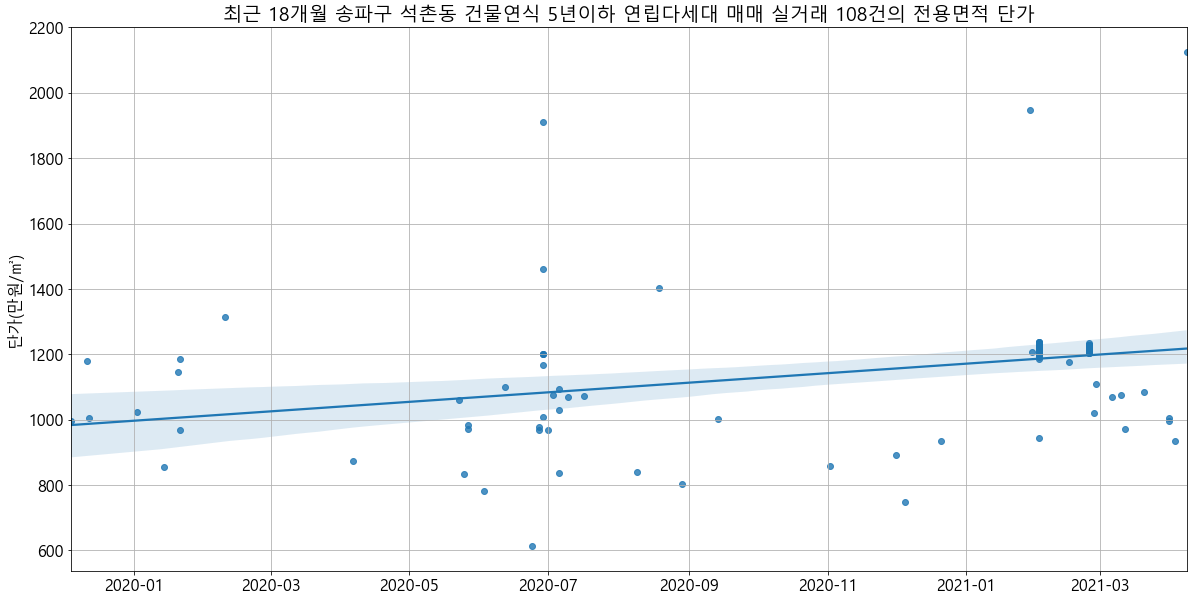

In [20]:
font = {'size': 16}
matplotlib.rc('font', **font)
f, ax = plt.subplots(figsize=(20,10))
plt.title('최근 {}개월 {} {} 건물연식 {}년이하 {} 매매 실거래 {}건의 전용면적 단가'.format(target_period, target_gu, target_dong, target_building_age, target_house, target_df.shape[0]))
plt.grid(True)
ax.xaxis.update_units(target_df['계약날짜'])
sns.regplot(x=ax.xaxis.convert_units(target_df['계약날짜']), y=target_df['단가(만원/㎡)'])
plt.savefig('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}_{}/산포도.png'.format(target_gu, target_dong, target_house, date_today_record))

In [21]:
target_last_df = target_df.drop_duplicates(subset=['지번주소', '건축년도'], keep='last').reset_index(drop=True)

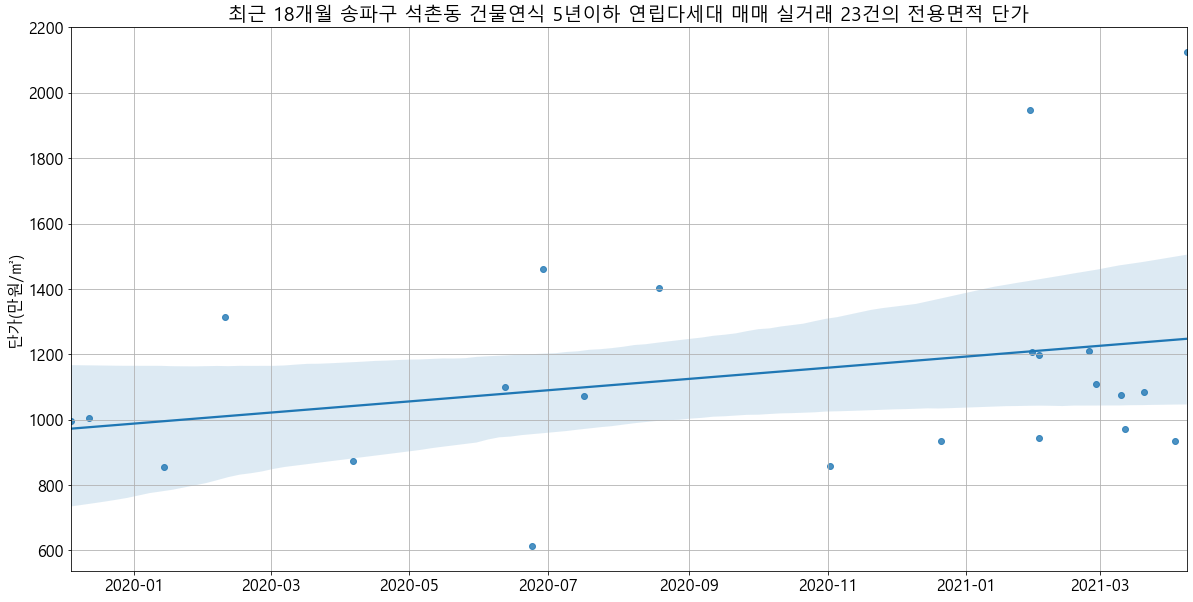

In [22]:
font = {'size': 16}
matplotlib.rc('font', **font)
f, ax = plt.subplots(figsize=(20,10))
plt.title('최근 {}개월 {} {} 건물연식 {}년이하 {} 매매 실거래 {}건의 전용면적 단가'.format(target_period, target_gu, target_dong, target_building_age, target_house, target_last_df.shape[0]))
plt.grid(True)
ax.xaxis.update_units(target_last_df['계약날짜'])
sns.regplot(x=ax.xaxis.convert_units(target_last_df['계약날짜']), y=target_last_df['단가(만원/㎡)'])
plt.savefig('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}_{}/마지막_산포도.png'.format(target_gu, target_dong, target_house, date_today_record))

In [23]:
target_last_df.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}_{}/마지막_실거래가.xlsx'.format(target_gu, target_dong, target_house, date_today_record), index=False)

In [24]:
target_df2 = house_merge_df[
    (house_merge_df['구'] == target_gu)
    &(house_merge_df['동'] == target_dong)
    #&(house_merge_df['계약날짜'] >= (date_today - pd.DateOffset(months=target_period)))
    &(house_merge_df['계약날짜기준_건물연식'] <= target_building_age)
    #&(house_merge_df['용도지역명1'].str.contains(target_purpose))
]
print(target_df2.shape)
target_df2.head()

(1498, 22)


,지번주소,도로명,건물(단지)명,전용면적(㎡),대지권면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면,구,동
192838,서울특별시 송파구 석촌동 150-0,석촌호수로18길 25,(150-0),38.60,18.97,10000,3,2006.0,0.0,2006-11-22,259.067358,15.0,대,200.4,제2종일반주거지역,지정되지않음,주상기타,평지,사다리형,소로각지,송파구,석촌동
192839,서울특별시 송파구 석촌동 150-0,석촌호수로18길 25,(150-0),23.25,11.43,8000,2,2006.0,0.0,2006-11-22,344.086022,15.0,대,200.4,제2종일반주거지역,지정되지않음,주상기타,평지,사다리형,소로각지,송파구,석촌동
192840,서울특별시 송파구 석촌동 150-0,석촌호수로18길 25,(150-0),38.60,18.97,10000,4,2006.0,0.0,2006-11-22,259.067358,15.0,대,200.4,제2종일반주거지역,지정되지않음,주상기타,평지,사다리형,소로각지,송파구,석촌동
192841,서울특별시 송파구 석촌동 150-0,석촌호수로18길 25,(150-0),38.60,18.97,10000,2,2006.0,0.0,2006-11-22,259.067358,15.0,대,200.4,제2종일반주거지역,지정되지않음,주상기타,평지,사다리형,소로각지,송파구,석촌동
192842,서울특별시 송파구 석촌동 150-0,석촌호수로18길 25,(150-0),39.59,19.46,15000,2,2006.0,0.0,2006-11-22,378.883556,15.0,대,200.4,제2종일반주거지역,지정되지않음,주상기타,평지,사다리형,소로각지,송파구,석촌동


In [25]:
target_df2 = get_index_applied_prices(target_df2)

<AxesSubplot:title={'center':'송파구 석촌동 계약날짜기준 건물연식 5년이하 연립다세대 매매 실거래 1498건의 전용면적 단가'}, xlabel='단가(만원/㎡)', ylabel='Count'>

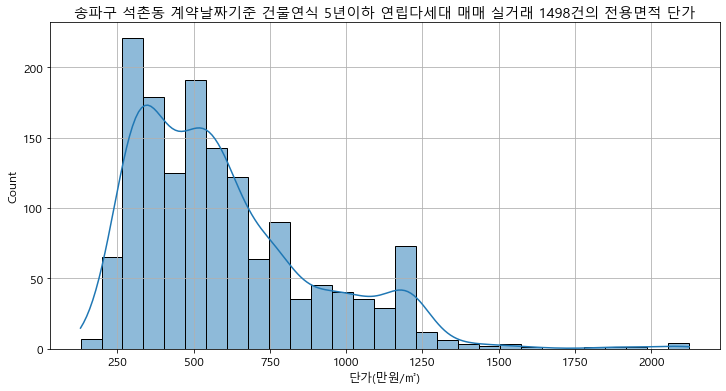

In [26]:
font = {'size': 12}
matplotlib.rc('font', **font)
f, ax = plt.subplots(figsize=(12,6))
plt.title('{} {} 계약날짜기준 건물연식 {}년이하 {} 매매 실거래 {}건의 전용면적 단가'.format(target_gu, target_dong, target_building_age, target_house, target_df2.shape[0]))
plt.grid(True)
sns.histplot(target_df2['단가(만원/㎡)'], kde=True)

In [27]:
target_df3 = target_df2[['지번주소', '건물(단지)명', '건축년도', '계약날짜', '단가(만원/㎡)', '평가날짜', '지수적용단가', '용도지역명1']]
target_df3 = target_df3.sort_values(['지번주소', '건축년도', '계약날짜']).reset_index(drop=True)
target_df3.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}_{}/지수적용_실거래가.xlsx'.format(target_gu, target_dong, target_house, date_today_record), index=False)

In [28]:
concat_df = pd.concat([target_df2])

In [29]:
concat_df = concat_df.sort_values(['지번주소', '건축년도', '전용면적(㎡)', '계약날짜']).reset_index(drop=True)
concat_df = concat_df.drop_duplicates(['지번주소', '건축년도', '전용면적(㎡)'], keep='last').reset_index(drop=True)

In [30]:
concat_df['단가평균'] = concat_df[['지번주소', '건축년도', '단가(만원/㎡)']].groupby(['지번주소', '건축년도']).transform('mean')['단가(만원/㎡)']
concat_df['지수적용단가평균'] = concat_df[['지번주소', '건축년도', '지수적용단가']].groupby(['지번주소', '건축년도']).transform('mean')['지수적용단가']

In [31]:
concat_df = concat_df.sort_values(['지번주소', '건축년도', '평가날짜']).reset_index(drop=True)
print(concat_df.shape)
concat_df.head()

(784, 26)


,지번주소,도로명,건물(단지)명,전용면적(㎡),대지권면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면,구,동,지수적용단가,평가날짜,단가평균,지수적용단가평균
0,서울특별시 송파구 석촌동 11-15,삼학사로16길 7,경원하우스,69.45,37.20,30300,5,2002.0,5.0,2007-07-11,436.285097,19.0,대,175.1,제2종일반주거지역,지정되지않음,다세대,평지,세로장방,소로한면,송파구,석촌동,724.568812,2021-03-01,436.285097,724.568812
1,서울특별시 송파구 석촌동 12-15,삼학사로14길 5,뮤지컬파크,19.54,16.53,21200,5,2015.0,0.0,2015-03-26,1084.953941,6.0,대,215.1,제2종일반주거지역,지정되지않음,다세대,평지,세로장방,세로한면(가),송파구,석촌동,1548.959167,2021-03-01,879.782856,1253.788889
2,서울특별시 송파구 석촌동 12-15,삼학사로14길 5,뮤지컬파크,27.50,26.45,31200,4,2015.0,0.0,2015-03-26,1134.545455,6.0,대,215.1,제2종일반주거지역,지정되지않음,다세대,평지,세로장방,세로한면(가),송파구,석촌동,1619.759619,2021-03-01,879.782856,1253.788889
3,서울특별시 송파구 석촌동 12-15,삼학사로14길 5,뮤지컬파크,41.54,26.45,32000,5,2015.0,0.0,2015-03-20,770.341839,6.0,대,215.1,제2종일반주거지역,지정되지않음,다세대,평지,세로장방,세로한면(가),송파구,석촌동,1099.796045,2021-03-01,879.782856,1253.788889
4,서울특별시 송파구 석촌동 12-15,삼학사로14길 5,뮤지컬파크,49.51,26.45,35900,2,2015.0,0.0,2015-03-27,725.106039,6.0,대,215.1,제2종일반주거지역,지정되지않음,다세대,평지,세로장방,세로한면(가),송파구,석촌동,1035.214127,2021-03-01,879.782856,1253.788889


In [32]:
concat_last_df = concat_df.drop_duplicates(subset=['지번주소', '건축년도'], keep='last')
print(concat_last_df.shape)
concat_last_df

(257, 26)


,지번주소,도로명,건물(단지)명,전용면적(㎡),대지권면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면,구,동,지수적용단가,평가날짜,단가평균,지수적용단가평균
0,서울특별시 송파구 석촌동 11-15,삼학사로16길 7,경원하우스,69.450,37.20,30300,5,2002.0,5.0,2007-07-11,436.285097,19.0,대,175.1,제2종일반주거지역,지정되지않음,다세대,평지,세로장방,소로한면,송파구,석촌동,724.568812,2021-03-01,436.285097,724.568812
5,서울특별시 송파구 석촌동 12-15,삼학사로14길 5,뮤지컬파크,49.710,26.45,34000,3,2015.0,0.0,2015-06-08,683.967009,6.0,대,215.1,제2종일반주거지역,지정되지않음,다세대,평지,세로장방,세로한면(가),송파구,석촌동,965.215485,2021-03-01,879.782856,1253.788889
8,서울특별시 송파구 석촌동 12-7,삼학사로14길 9,스카이빌(12-7),65.450,39.09,22000,4,2002.0,4.0,2006-11-20,336.134454,19.0,대,174.8,제2종일반주거지역,지정되지않음,다세대,평지,세로장방,세로한면(가),송파구,석촌동,653.922743,2021-03-01,281.755670,548.133161
9,서울특별시 송파구 석촌동 13-15,백제고분로33길 3-10,그린빌(13-15),41.400,25.17,13000,2,2004.0,2.0,2006-11-02,314.009662,17.0,대,173.2,제2종일반주거지역,지정되지않음,다세대,평지,세로장방,세로한면(가),송파구,석촌동,610.880727,2021-03-01,314.009662,610.880727
13,서울특별시 송파구 석촌동 150-0,석촌호수로18길 25,(150-0),103.490,50.82,36500,5,2006.0,0.0,2006-11-22,352.691081,15.0,대,200.4,제2종일반주거지역,지정되지않음,주상기타,평지,사다리형,소로각지,송파구,석촌동,686.132340,2021-03-01,333.682004,649.151698
14,서울특별시 송파구 석촌동 150-17,백제고분로37나길 11,백제맨션,67.390,33.32,33200,2,2003.0,5.0,2008-03-06,492.654697,18.0,대,248.0,제2종일반주거지역,지정되지않음,다세대,평지,정방형,세로한면(가),송파구,석촌동,678.235836,2021-03-01,492.654697,678.235836
18,서울특별시 송파구 석촌동 150-18,백제고분로37나길 13,엘리움파크,50.210,28.13,43000,2,2018.0,2.0,2020-01-14,856.403107,3.0,대,234.7,제2종일반주거지역,지정되지않음,다세대,평지,정방형,세로한면(가),송파구,석촌동,977.236903,2021-03-01,864.462075,1010.424819
19,서울특별시 송파구 석촌동 150-6,백제고분로37나길 6,선경리치빌,57.840,32.87,25500,2,2003.0,4.0,2007-12-03,440.871369,18.0,대,198.4,제2종일반주거지역,지정되지않음,다세대,평지,가로장방,세로각지(가),송파구,석촌동,666.816883,2021-03-01,440.871369,666.816883
23,서울특별시 송파구 석촌동 150-8,백제고분로36가길 19-8,이수빌,63.880,34.73,32000,2,2008.0,2.0,2010-03-11,500.939261,13.0,대,231.5,제2종일반주거지역,지정되지않음,단독,평지,가로장방,세로한면(가),송파구,석촌동,658.928605,2021-03-01,566.649252,763.543301
24,서울특별시 송파구 석촌동 154-4,석촌호수로18길 19-7,(154-4),44.385,27.38,23500,3,2014.0,0.0,2014-07-18,529.458150,7.0,대,167.3,제2종일반주거지역,지정되지않음,다세대,평지,세로장방,세로한면(가),송파구,석촌동,780.523508,2021-03-01,529.458150,780.523508


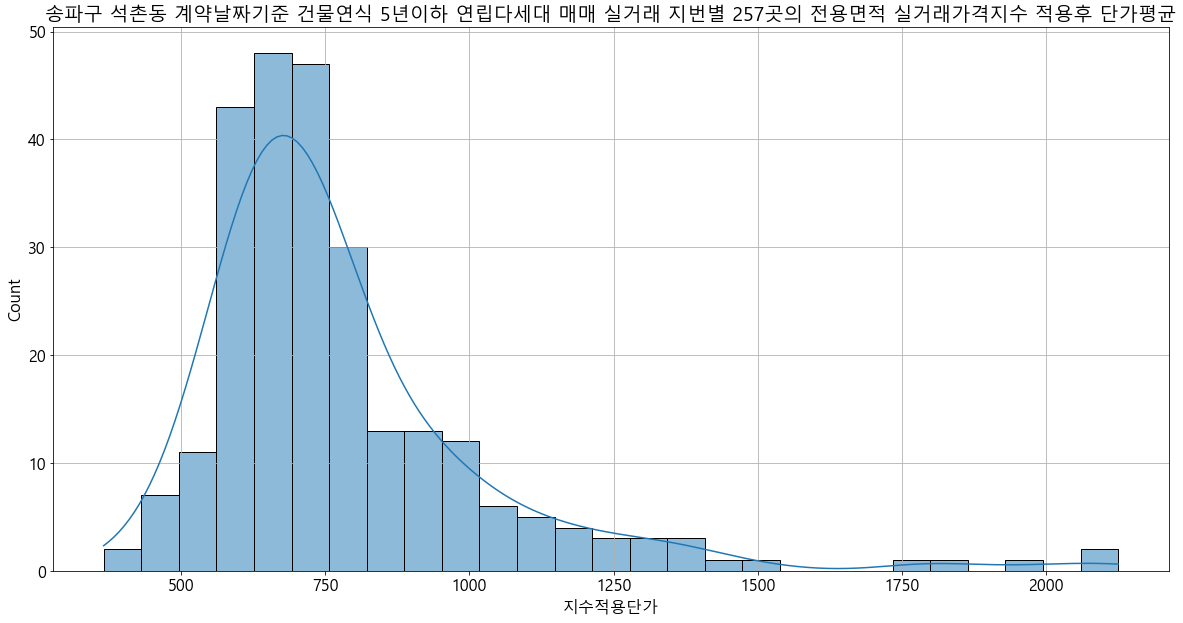

In [33]:
font = {'size': 16}
matplotlib.rc('font', **font)
f, ax = plt.subplots(figsize=(20,10))
plt.title('{} {} 계약날짜기준 건물연식 {}년이하 {} 매매 실거래 지번별 {}곳의 전용면적 실거래가격지수 적용후 단가평균'.format(target_gu, target_dong, target_building_age, target_house, concat_last_df.shape[0]))
plt.grid(True)
sns.histplot(concat_last_df['지수적용단가'], kde=True)
plt.savefig('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}_{}/지번별_분포도.png'.format(target_gu, target_dong, target_house, date_today_record))

In [34]:
concat_last_df = concat_last_df.sort_values(['지번주소']).reset_index(drop=True)

In [35]:
concat_last_df = concat_last_df[['지번주소', '건물(단지)명', '건축년도', '계약날짜', '단가(만원/㎡)', '평가날짜', '지수적용단가', '용도지역명1']]
concat_last_df.rename(columns={'계약날짜':'마지막_계약날짜'}, inplace=True)
concat_last_df.head()

,지번주소,건물(단지)명,건축년도,마지막_계약날짜,단가(만원/㎡),평가날짜,지수적용단가,용도지역명1
0,서울특별시 송파구 석촌동 11-15,경원하우스,2002.0,2007-07-11,436.285097,2021-03-01,724.568812,제2종일반주거지역
1,서울특별시 송파구 석촌동 12-15,뮤지컬파크,2015.0,2015-06-08,683.967009,2021-03-01,965.215485,제2종일반주거지역
2,서울특별시 송파구 석촌동 12-7,스카이빌(12-7),2002.0,2006-11-20,336.134454,2021-03-01,653.922743,제2종일반주거지역
3,서울특별시 송파구 석촌동 13-15,그린빌(13-15),2004.0,2006-11-02,314.009662,2021-03-01,610.880727,제2종일반주거지역
4,서울특별시 송파구 석촌동 150-0,(150-0),2006.0,2006-11-22,352.691081,2021-03-01,686.132340,제2종일반주거지역


In [36]:
concat_last_df.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}_{}/지수적용_마지막_실거래가.xlsx'.format(target_gu, target_dong, target_house, date_today_record), index=False)